In [55]:
import graph_tool.all as gt
from math import sqrt

In [56]:
from random import *

In [57]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
formatedGraphPath="../graphs/formatted/"
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [58]:
import igraph as ig

In [59]:
F=ig.Graph.Read("../graphs/formatted/facebook_combined.txt",format="ncol").as_undirected()

In [60]:
nbWorkers=100

In [61]:
import signal
class TimeoutException(Exception):
    pass

In [62]:
def deadline(timeout, *args):
    """is a the decotator name with the timeout parameter in second"""
    def decorate(f):
        """ the decorator creation """
        def handler(signum, frame):
            """ the handler for the timeout """
            raise TimeoutException() #when the signal have been handle raise the exception

        def new_f(*args):
            """ the initiation of the handler, 
            the lauch of the function and the end of it"""
            signal.signal(signal.SIGALRM, handler) #link the SIGALRM signal to the handler
            signal.alarm(timeout) #create an alarm of timeout second
            res = f(*args) #lauch the decorate function with this parameter
            signal.alarm(0) #reinitiate the alarm
            return res #return the return value of the fonction
    
        new_f.__name__ = f.__name__
        return new_f
    return decorate

In [63]:
import colorsys
import math
def colorDistribution(nbColors):
    assert nbColors>=1
    base=13
    maxValues=4
    nbValues=math.ceil(nbColors/base)
    if nbValues==1:
        values=[1]
    else:
        denominatorV=min(maxValues,nbValues)
        values=[min(1,0.5+0.5*v/(denominatorV-1)) for v in range(denominatorV)]

    if nbColors==1:
        hues=[0]
    else:
        denominatorH=min(base,nbColors)
        hues=[h/(denominatorH) for h in range(denominatorH)]
    sats=[1]
    nbSat=1
    if nbValues>maxValues:
        nbSat=math.ceil(nbColors/(denominatorH*denominatorV))
        sats=[min(1,0.4+0.5*s/(nbSat-1)) for s in range(nbSat)]
    HSVs=[]
    
    for value in values[::-1]:
        for i in range(len(hues)):
            for sat in sats[::-1]:
                if i%2==0:
                    HSVs.append((hues[i//2],sat,value))
                else:
                    HSVs.append((hues[-i//2],sat,value))

    colours = [colorsys.hsv_to_rgb(hue, sat, value) for hue,sat,value in HSVs]
    return colours

In [64]:
def findCommunities(graph):
    detect_communities=[graph.community_multilevel,
                        graph.community_label_propagation,
                        graph.community_leading_eigenvector]
    
    partition=detect_communities[0]()
    
    colours=colorDistribution(len(partition))

    for idx, c in enumerate(partition):
        color=colours[idx]
        for v in c:
            partition.graph.vs[v]["color"]=color
            partition.graph.vs[v]["cluster"]=idx
            for e in partition.graph.incident(v):
                ed=partition.graph.es[e]
                if ed.source in c and ed.target in c:
                    ed["color"]=[0.,0.,0.,1.]
                else:
                    ed["color"]=[0.5,0.5,0.5,1.]
    return partition

In [65]:
def chooseVertexByMinBetweenness(graph):
    node=None
    minBetweenness = -1
    for idx, betweenness in enumerate(graph.betweenness()):
        if betweenness < minBetweenness or minBetweenness == -1 :
            node= idx
        if betweenness==0:
            break
    return node

In [66]:
def chooseVertexByMaxEccentricity(graph):
    node=None
    maxEccentricity = 0
    diameter=graph.diameter()
    for idx, ecc in enumerate(graph.eccentricities()):
        if ecc > maxEccentricity:
            node= idx
        if maxEccentricity==diameter:
            break
    return node

In [67]:
def chooseVertexMaxShortestPathsSum(graph):
    node=None
    maxPCCSum = 0
    for idx, pccs in enumerate(graph.shortest_paths_dijkstra()):
        sumPCCs=sum(pccs)
        if sumPCCs > maxPCCSum:
            node= idx
    return node

In [68]:
choiceFunctions=[chooseVertexByMinBetweenness,chooseVertexByMaxEccentricity,chooseVertexMaxShortestPathsSum]
chosenFunction=choiceFunctions[2]
def chooseVertex(graph,choiceFunction=chosenFunction):
    assert len(graph.vs)>0, "Can't choose a vertex in an empty graph." 
    node=None
    node=choiceFunction(graph)
    print(graph.vs[node])
    assert node is not None
    return node

In [69]:
def distanceCrit(value):
    outputs=[0,0,5,10]
    if value>=len(outputs):
        return outputs[-1]
    return outputs[value]

In [70]:
def maxMinPCCNodeSelection(dictPCC):
    assert dictPCC!={}
    chosenId=None
    nbNodes=len(list(dictPCC.values())[0])
    maxDist=-1
    maxSumDist=-1
    maxDistNode=None
    for nodeId in range(nbNodes):
        if nodeId not in dictPCC.keys():
            minDist=-1
            minDistNode=nodeId
            for chosenNode in dictPCC.keys():
                if minDist==-1 or dictPCC[chosenNode][nodeId]<minDist:
                    minDist=dictPCC[chosenNode][nodeId]
            #if equivalent on criterion 1, calculate criterion 2
            sumDist=-1
            if maxSumDist==-1 or minDist==maxDist:
                #sumDist=sum([dictPCC[chosenNode][nodeId] for chosenNode in dictPCC.keys()])
                #sumDist=random()
                sumDist=sum([distanceCrit(dictPCC[chosenNode][nodeId]) for chosenNode in dictPCC.keys()])
            #if better crit1 or equal crit1 but better crit2
            if minDist>maxDist or (minDist==maxDist and sumDist>maxSumDist):
                maxDist=minDist
                maxDistNode=minDistNode
                maxSumDist=sumDist
    chosenId=maxDistNode
    return chosenId

In [71]:
def maxShortestPathNodesSelection(graph,nbNodes,boundaryNodes=[]):
    assert len(graph.vs)-len(boundaryNodes)>= nbNodes, "{} {} {}".format(len(graph.vs),nbNodes,len(boundaryNodes))
    if boundaryNodes==[]:
        chosenIds=[chooseVertex(graph)]
    else:
        chosenIds=boundaryNodes.copy()
    #BFS initial des noeuds dans chosenIds
    matPCC=graph.shortest_paths_dijkstra(chosenIds)
    dictPCC={chosenId:matPCC[idxPCC] for idxPCC,chosenId in enumerate(chosenIds)}
    
    #nbNodes fois
    while len(chosenIds)-len(boundaryNodes)<nbNodes:
        chosenNodeId=maxMinPCCNodeSelection(dictPCC)

        #BFS du nouveau noeud
        dictPCC[chosenNodeId]=graph.shortest_paths_dijkstra(chosenNodeId)[0] #On prend la ligne de la matrice qui correspond au noeud
        chosenIds.append(chosenNodeId)
    assert len(chosenIds)==len(boundaryNodes)+nbNodes
    return chosenIds[len(boundaryNodes):]

In [72]:
def defineBoundary(graph, clusterVertices, clusterId):
    boundaryVertices=set()
    for v in clusterVertices: #Trouver les successeurs hors cluster aka les noeuds frontaliers au cluster
        boundaryVertices.update([bv for bv in v.successors() if bv["cluster"]!=clusterId])
    boundaryVertices=list(boundaryVertices)
    
    return boundaryVertices

In [73]:
def drawBoundedCluster(boundedCluster,workerIds,clusterId):
    for node in boundedCluster.vs:
        if node["name"]in boundedCluster.vs[workerIds]["name"]:
            node["shape"]="triangle"

    ig.plot(boundedCluster,"../graphs/img/cluster{}.png".format(clusterId))

In [74]:
withBoundary=False
def assignWorkersInCommunity(graph,clusterGraph,clusterId,withBoundary=withBoundary):
    clusterVertices=[v for v in graph.vs if v["cluster"]==clusterId]
    
    boundaryVertices=[]
    if withBoundary:
        boundaryVertices=defineBoundary(graph,clusterVertices,clusterId)
    
    boundedCluster=graph.induced_subgraph(boundaryVertices+clusterVertices)
    
    #Réidentification des noeuds du graphe global vers le sous-graphe
    #clusterVertices=[boundedCluster.vs.find(v["name"]) for v in clusterVertices]
    boundaryVertices=[boundedCluster.vs.find(v["name"]) for v in boundaryVertices]
    boundaryVerticesIds=[bv.index for bv in boundaryVertices]
    
    workerIds=maxShortestPathNodesSelection(boundedCluster,clusterGraph.vs[clusterId]["nb_workers"],boundaryVerticesIds)
    
    #drawBoundedCluster(boundedCluster,workerIds,clusterId)
    
    return boundedCluster.vs[workerIds]["name"]

In [75]:
def atLeastNWorkers(minWorkers):
    def wrap(f):
        def wrapped_f(graph,partition,clusterGraph,nWorkers):
            #Chaque cluster aura au moins un worker en lui
            for cluster in clusterGraph.vs:
                cluster["nb_workers"]=minWorkers

            #Attribuer le nombre de workers réel
            remainingWorkers=nWorkers-minWorkers*len(clusterGraph.vs)
            res=f(graph,partition,clusterGraph,remainingWorkers)
            return res
        return wrapped_f
    return wrap

In [76]:
import pandas as pd
import numpy as np

def subgraphCapacity(graph, minDist):
    nodes=graph.vs
    candidates=set()
    matPCC=graph.shortest_paths_dijkstra()

    dfPCC=pd.DataFrame(matPCC,nodes["name"],nodes["name"])
    #print((dfPCC > minDist).values)
    g = ig.Graph.Adjacency((dfPCC >= minDist).values.tolist()).as_undirected()
    g.vs["name"]=nodes["name"]
    #ig.plot(g,"../graphs/img/graph.png")
    #print(g)
    try:
        cliques=deadline(10)(g.largest_cliques)()
        candidates=[nodes[idx]["name"] for idx in cliques[0]]
        
        print("n_clq",len(cliques),"l_clq", len(cliques[0]),"a clq", cliques[0])
        print("len(c)",len(candidates),"len(n)",len(nodes))
        yield candidates
    except TimeoutException:
        print("Timeout")
        candidates=None

In [77]:
import itertools
@atLeastNWorkers(0)
def capacityBasedWorkerAssignment(graph,partition,clusterGraph,nWorkers):
    assignedWorkers=0
    nbClusters=len(partition)
    candidatesDict={clusterId:{} for clusterId in range(nbClusters)}
    diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]
    
    cliques=[idx for idx in range(nbClusters) if diameters[idx]==1]
    
    for clusterId, subgraph in enumerate(partition.subgraphs()):
        diameter=diameters[clusterId]
        radius=int(subgraph.radius())
        
        print("d",diameter,"r", radius)
        if clusterId not in cliques:
            for eccentricity in reversed(list(range(2,diameter+1))):#if diameter is 1 => clique => only one worker should be placed
                print("e",eccentricity)
                candidatesDict[clusterId][eccentricity]=subgraphCapacity(subgraph,eccentricity)
        else:
            candidatesDict[clusterId][1]=None
            clusterGraph[clusterId]["nb_workers"]=1 #because all nodes know each other
    print(candidatesDict)
    
    betweenness=clusterGraph.betweenness()
    
    sortedBtwnsIdx=sorted(range(len(clusterGraph.vs)), key=lambda k: (diameters[k],betweenness[k]), reverse=True)
    print(sortedBtwnsIdx)
    
    eccIdx=diameters.copy()
    for idx in range(nbClusters):
        #candidatesDict[idx][eccIdx[idx]]=next(candidatesDict[idx][eccIdx[idx]],None)
        for key in candidatesDict[idx].keys():
            candidatesDict[idx][key]=next(candidatesDict[idx][key],None)
            #None values happen when the search space is vast, i.e close to the initial graph, when minDist is low (2 or 3)
            #This means there isn't a particular need to find optimal values if nodes are that close, but if we find a solution anyway, good for us.
            #If we didn't find a solution, we'll use approximation functions later

    print(candidatesDict)
    #Now we have a certain amount of clusters with distantiated nodes and may have clusters which timed out on the search
    #Those timed out clusters will receive workers through other methods
    
    nbCurrentWorkers={(minDist,maxDist):sum([len(candidatesDict[idx][min(eccIdx[idx],maxDist)]) 
                                   for idx in range(nbClusters) 
                                   if candidatesDict[idx][min(eccIdx[idx],maxDist)] is not None and eccIdx[idx]>=minDist]) 
                      for (minDist,maxDist) in itertools.product(range(2, max(diameters)+1),range(2, max(diameters)+1))
                         if minDist<=maxDist}
    print("nbCurWrks",nbCurrentWorkers)
    
    unsolvedClusters={(minDist,maxDist):[cluster for cluster in range(nbClusters)
                                            if eccIdx[cluster]<minDist 
                                            or all([candidatesDict[cluster][ecc] is None 
                                                    for ecc in range(minDist,min(eccIdx[cluster],maxDist)+1)])
                                        ] for (minDist,maxDist) in nbCurrentWorkers.keys()}
    print("unsolved",unsolvedClusters)
    
    unsolvedClustersWorkers={(minDist,maxDist):sum([1+diameters[cluster]//2
                                                 for cluster in unsolvedClusters[(minDist,maxDist)]])
                                 for (minDist,maxDist) in nbCurrentWorkers.keys()}
    print("unsolvedNbWorkers",unsolvedClustersWorkers)
    
    totalWorkersInCliques=len(cliques)
    
    maxMinDistEnoughWorkers=1
    counter=0
    while maxMinDistEnoughWorkers==1:
        counter+=1
        maxMinDistEnoughWorkers=max([minDist for (minDist,maxDist),nbPlacedWorkers in nbCurrentWorkers.items() 
                                         if nbPlacedWorkers 
                                             + min(counter*len(unsolvedClusters[(minDist,maxDist)]),
                                                   unsolvedClustersWorkers[(minDist,maxDist)]) 
                                             + totalWorkersInCliques
                                             >=nWorkers],
                                    default=1)
    print("nbFoisLen",counter)
    
    if maxMinDistEnoughWorkers==1:
        print("We haven't found a solution *yet*, might as well abort...")
    else:
        print("Best minDist: ",maxMinDistEnoughWorkers)
        maxMaxDistEnoughWorkers=max([maxDist for (minDist,maxDist),nbPlacedWorkers in nbCurrentWorkers.items() 
                                     if minDist==maxMinDistEnoughWorkers and 
                                         nbPlacedWorkers + unsolvedClustersWorkers[(minDist,maxDist)] + totalWorkersInCliques
                                         >=nWorkers ])
        minMax=(maxMinDistEnoughWorkers,maxMaxDistEnoughWorkers)
        print("Best maxDist: ",maxMaxDistEnoughWorkers)
        print("Workers to be assigned: ",nWorkers)
        print("Workers in clique communities: ",totalWorkersInCliques)
        print("Workers in unsolved communities: ",unsolvedClustersWorkers[minMax])
        newEccIdx=[min(idx,maxMaxDistEnoughWorkers) for idx in eccIdx]
        assignedSolvedWorkers={cIdx:{"minDist":newEccIdx[cIdx],
                                     "workers":candidatesDict[cIdx][newEccIdx[cIdx]]} 
                                for cIdx in range(nbClusters) 
                                if newEccIdx[cIdx]>= maxMinDistEnoughWorkers 
                                       and candidatesDict[cIdx][newEccIdx[cIdx]] is not None}
        print("Number of workers in solved communities: ",sum([len(value) for value in assignedSolvedWorkers.values()]))
        print("Workers in solved communities: ",assignedSolvedWorkers)
        clusterIdsByMinDist=sorted(assignedSolvedWorkers.keys(), key=lambda k: assignedSolvedWorkers[k]["minDist"], reverse=False)
        #Check if you can assign 1 worker to clique (1 per clq) and unsolved clusters and complete with solved cluster workers
        workersToAssignInSolvedClusters=nWorkers-totalWorkersInCliques-unsolvedClustersWorkers[minMax]
        
        for cluster in cliques:
            clusterGraph.vs[cluster]["nb_workers"]=1
        assignedWorkers+=len(cliques)
            
        print("w",workersToAssignInSolvedClusters,nbCurrentWorkers[minMax])
        if workersToAssignInSolvedClusters<nbCurrentWorkers[minMax]:
            #Unsolved clusters get 1 worker
            for cluster in unsolvedClusters[minMax]:
                clusterGraph.vs[cluster]["nb_workers"]=1
            assignedWorkers+=len(unsolvedClusters[minMax])
            
            #We need to remove some workers in the solved clusters
            #We first do as if we put all of them in
            assignedWorkers+=nbCurrentWorkers[minMax]
            for cluster in assignedSolvedWorkers.keys():
                #We keep the exact workers lists in solved clusters
                clusterGraph.vs[cluster]["nb_workers"]=len(assignedSolvedWorkers[cluster]["workers"])
            #Then we remove excess workers
            clustersPerDist={currentDist:[cluster for cluster,infos in assignedSolvedWorkers.items() 
                                          if infos["minDist"]==currentDist]
                                for currentDist in reversed(list(range(minMax[0],minMax[1]+1)))
                            }
            print("-1",assignedWorkers)
            while assignedWorkers>nbWorkers:
                for clusters in clustersPerDist.values():
                    succeeded=True
                    while(succeeded):
                        succeeded=False
                        for cluster in clusters:
                            if clusterGraph.vs[cluster]["nb_workers"]>2:
                                assignedSolvedWorkers[cluster]["workers"].pop()
                                assignedWorkers-=1
                                succeeded=True
                                print("0",assignedWorkers)
                            print("1",assignedWorkers)
                            if assignedWorkers==nbWorkers:
                                succeeded=True
                                break
                            print("1a",assignedWorkers)
                        print("2",assignedWorkers)
                    print("3",assignedWorkers)
                    if assignedWorkers==nbWorkers:
                        break
                print("4",assignedWorkers)
            print("5",assignedWorkers)
        else:#We know there is enough room in unsolved clusters
            for cluster in assignedSolvedWorkers.keys():
                #We keep the exact workers lists in solved clusters
                clusterGraph.vs[cluster]["nb_workers"]=len(assignedSolvedWorkers[cluster]["workers"])
            assignedWorkers+=nbCurrentWorkers[minMax]
            #We assign the unsolved cluster workers with the diameter based method
            remainingWorkers=nbWorkers-assignedWorkers
            
            clusterGraph=diameterWorkerAssignment(graph,partition,clusterGraph,remainingWorkers,unsolvedClusters[minMax])
            assignedWorkers+=remainingWorkers
            
    assert all([cluster["nb_workers"]>=1 for cluster in clusterGraph.vs]), "{}".format(clusterGraph.vs["nb_workers"])
    assert assignedWorkers==nWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,nWorkers)
    clustersToFill=[*unsolvedClusters[minMax],*cliques]
    return [],clusterGraph,clustersToFill

In [78]:
@atLeastNWorkers(1)
def sizeOrderedRoundRobinWorkerAssignement(graph,partition,clusterGraph,remainingWorkers):
    graphSize=len(graph.vs)
    relativeSizes=[len(partition.subgraph(int(cluster["name"][1:])).vs)/graphSize for cluster in clusterGraph.vs]

    sortedIdxPerSize=sorted(range(len(relativeSizes)), key=lambda k: relativeSizes[k], reverse=True)
    sortedSizes=sorted(relativeSizes)

    #Round Robin par ordre de taille des clusters
    currentCluster=0
    while remainingWorkers>0:
        currentSortedCluster=sortedIdxPerSize[currentCluster]
        if clusterGraph.vs[currentSortedCluster]["nb_workers"]<len(partition.subgraph(currentSortedCluster).vs):
            clusterGraph.vs[currentSortedCluster]["nb_workers"]+=1
            remainingWorkers-=1
        currentCluster+=1
        if currentCluster>=len(clusterGraph.vs):
            currentCluster=0
    return [],clusterGraph, range(len(partition))

In [79]:
@atLeastNWorkers(1)
def sizeProRataWorkerAssignement(graph,partition,clusterGraph,remainingWorkers):
    graphSize=len(graph.vs)
    relativeSizes=[len(partition.subgraph(int(cluster["name"][1:])).vs)/graphSize for cluster in clusterGraph.vs]

    proRataWorkers=[remainingWorkers*size for size in relativeSizes]
    intProRataWorkers=[int(prw) for prw in proRataWorkers]
    
    assignedWorkers=sum(intProRataWorkers)
    if assignedWorkers < remainingWorkers:
        remainingProRataWorkers=[prw - prw//1 for prw in proRataWorkers]
        sortedIdx=sorted(range(len(remainingProRataWorkers)), key=lambda k: remainingProRataWorkers[k], reverse=True)

        for i in range(remainingWorkers-assignedWorkers):
            intProRataWorkers[sortedIdx[i]]+=1
            assignedWorkers+=1
        
    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["nb_workers"]+=intProRataWorkers[idx]
    
    assert assignedWorkers==remainingWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,remainingWorkers)
    return [],clusterGraph, range(len(partition))

In [80]:
@atLeastNWorkers(1)
def diameterProRataWorkerAssignement(graph,partition,clusterGraph,remainingWorkers):

    diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]
    sumDiameters=sum(diameters)
    
    proRataWorkers=[remainingWorkers*diameter/sumDiameters for diameter in diameters]
    intProRataWorkers=[int(prw) for prw in proRataWorkers]
    
    assignedWorkers=sum(intProRataWorkers)
    if assignedWorkers < remainingWorkers:
        remainingProRataWorkers=[prw - prw//1 for prw in proRataWorkers]
        sortedIdx=sorted(range(len(remainingProRataWorkers)), key=lambda k: remainingProRataWorkers[k], reverse=True)

        for i in range(remainingWorkers-assignedWorkers):
            intProRataWorkers[sortedIdx[i]]+=1
            assignedWorkers+=1
        
    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["nb_workers"]+=intProRataWorkers[idx]
    
    assert assignedWorkers==remainingWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,remainingWorkers)
    return [],clusterGraph, range(len(partition))

In [81]:
@atLeastNWorkers(0)
def diameterWorkerAssignment(graph,partition,clusterGraph,remainingWorkers,clustersToFill=None):
    diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]
    
    if clustersToFill is None:
        clustersToFill=range(len(clusterGraph.vs))
    
    workers=[1+diameter//2 for diameter in diameters]
    assignedWorkers=sum([nb for idx,nb in enumerate(workers) if idx in clustersToFill])
    for idx in clustersToFill:
        clusterGraph.vs[idx]["nb_workers"]=workers[idx]

    while assignedWorkers>remainingWorkers:
        sortedIdx=sorted(clustersToFill, key=lambda k: workers[k], reverse=True)

        for i in range(assignedWorkers-remainingWorkers):
            if clusterGraph.vs[sortedIdx[i%len(sortedIdx)]]["nb_workers"]>1:
                clusterGraph.vs[sortedIdx[i%len(sortedIdx)]]["nb_workers"]-=1
                assignedWorkers-=1
    
    if assignedWorkers<remainingWorkers:
        a,clusterGraph,c=sizeOrderedRoundRobinWorkerAssignement(graph,partition,clusterGraph,remainingWorkers-assignedWorkers)
        assignedWorkers+=remainingWorkers
    
    assert assignedWorkers==remainingWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,remainingWorkers)
    return [],clusterGraph,clustersToFill

In [92]:
def assignWorkers(graph,nWorkers):
    assert nWorkers>=0, "{} workers to assign: Number of workers to assign must be positive or zero".format(nWorkers)
    assert len(graph.vs)>=nWorkers, "{} workers to assign on {} nodes: Can't assign more workers than there are vertices".format(nWorkers,len(graph.vs))
    partition=findCommunities(graph)
    
    clusterGraph=partition.cluster_graph("first")

    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["name"]="C{}".format(idx)

    workerIds=[]
    clusterIds=[]
    if len(partition)<nWorkers:        
        workerAssignment=[sizeProRataWorkerAssignement,
                          sizeOrderedRoundRobinWorkerAssignement,
                          diameterProRataWorkerAssignement,
                          diameterWorkerAssignment,
                          capacityBasedWorkerAssignment,
                          #subpartitioning
                         ]

        workerIds,clusterGraph,clusterIds=workerAssignment[2](graph, partition,clusterGraph, nWorkers)
        
    elif len(partition)==nWorkers:
        #1cluster/1worker
        for cluster in clusterGraph.vs:
            cluster["nb_workers"]=1
        clusterIds=range(len(partition))
    else:
        clusterIds=maxShortestPathNodesSelection(clusterGraph,nWorkers)
        for cluster in clusterGraph.vs:
            if cluster.index in clusterIds:
                cluster["nb_workers"]=1
            else:
                cluster["nb_workers"]=0

    #Etape2
    #for chaque cluster de workers
    #prendre son sous-graphe+ les noeuds frontaliers d'autres clusters, BFS des frontières et Etape1 nb_workers fois
    for clusterId in clusterIds:
        %time workerIds.extend(assignWorkersInCommunity(graph,clusterGraph,clusterId))
    
    assert len(workerIds)==nWorkers, "Assigned {} workers instead of {}".format(len(workerIds),nWorkers)
    return workerIds,partition,clusterGraph,clusterIds

In [29]:
%time workerIds,partition,clusterGraph,clusterIds=assignWorkers(F,nbWorkers)
print(workerIds)

igraph.Vertex(<igraph.Graph object at 0x7f120e71f040>, 349, {'name': 'V2740', 'color': (1, 0.0, 0.0), 'cluster': 0})
CPU times: user 18.3 ms, sys: 0 ns, total: 18.3 ms
Wall time: 18.1 ms
igraph.Vertex(<igraph.Graph object at 0x7f120e6ef040>, 430, {'name': 'V1967', 'color': (1, 0.0, 0.4615384615384617), 'cluster': 1})
CPU times: user 34.3 ms, sys: 385 µs, total: 34.6 ms
Wall time: 34.3 ms
igraph.Vertex(<igraph.Graph object at 0x7f120e6ef040>, 434, {'name': 'V1911', 'color': (1, 0.46153846153846156, 0.0), 'cluster': 2})
CPU times: user 44.6 ms, sys: 7.82 ms, total: 52.4 ms
Wall time: 52.4 ms
igraph.Vertex(<igraph.Graph object at 0x7f120e6ef040>, 422, {'name': 'V2656', 'color': (1, 0.0, 0.9230769230769234), 'cluster': 3})
CPU times: user 39.2 ms, sys: 0 ns, total: 39.2 ms
Wall time: 38.8 ms
igraph.Vertex(<igraph.Graph object at 0x7f120e6ef040>, 542, {'name': 'V3434', 'color': (1, 0.9230769230769231, 0.0), 'cluster': 4})
CPU times: user 58.5 ms, sys: 0 ns, total: 58.5 ms
Wall time: 57.4 ms

### What if we distantiated workers based on the whole graph (as if one unique community)

%time workerIds=F.vs[maxShortestPathNodesSelection(F,nbWorkers)]["name"]

### Arbitrary workers

## Plot

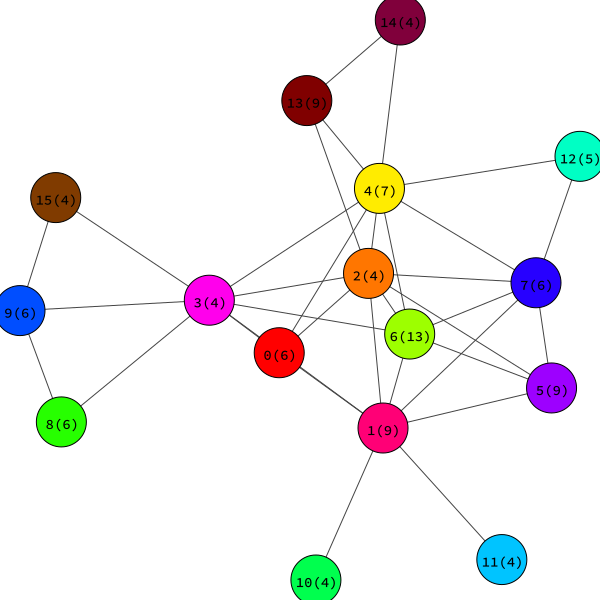

In [30]:
for idx, cluster in enumerate(clusterGraph.vs):
    if cluster.index in clusterIds:
        cluster["size"]=50
    cluster["color"]=partition.subgraph(idx).vs[0]["color"]
    cluster["label"]="{}({})".format(idx,cluster["nb_workers"])
ig.plot(clusterGraph)

In [31]:
for v in F.vs:
    if v["name"] in workerIds:
        v["size"]=25
        v["shape"]="triangle"
    else:
        v["size"]=1
        v["shape"]="circle"

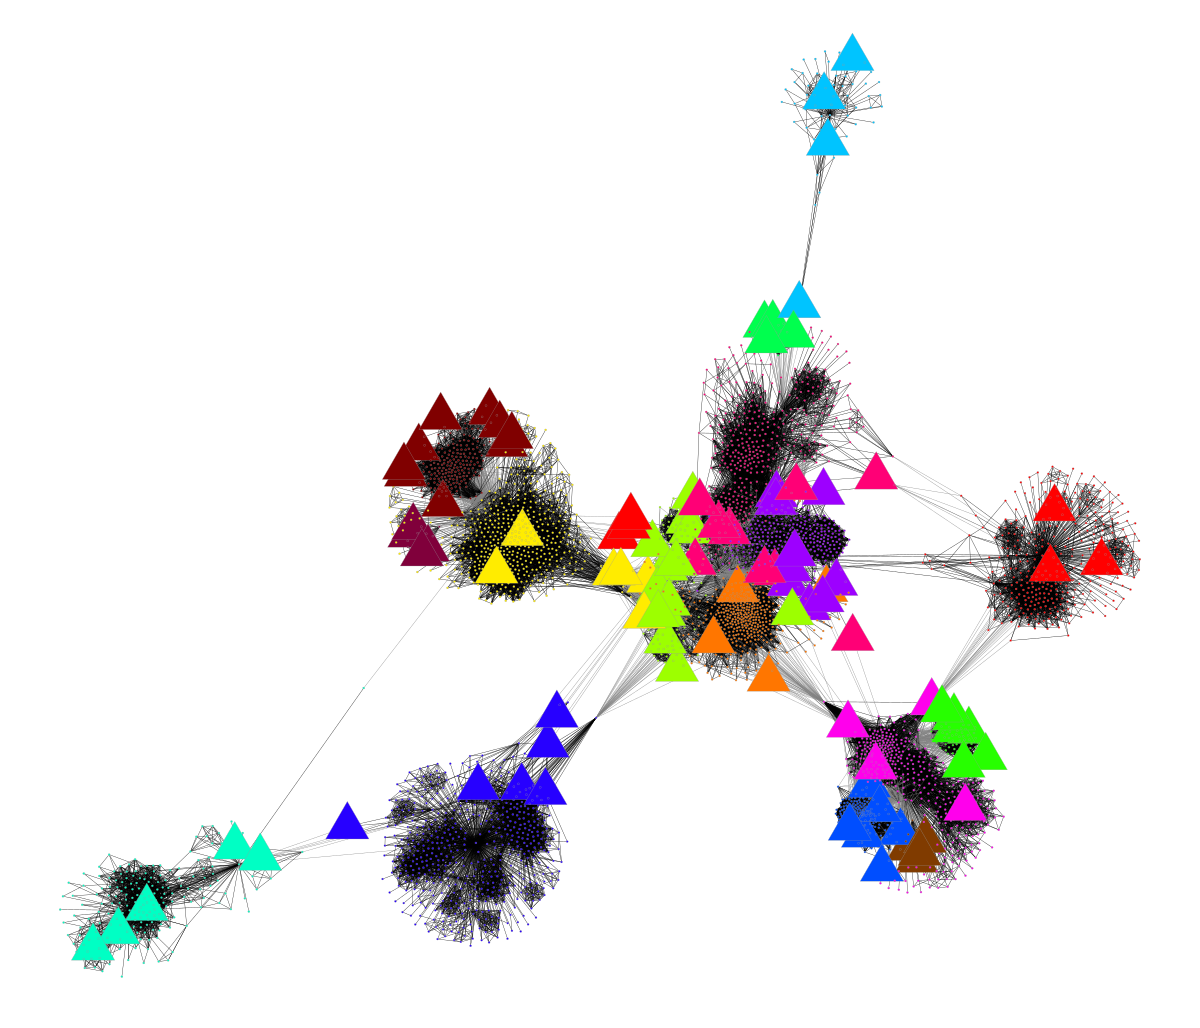

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f120e71f670, at 0x7f120e71fc10>

In [32]:
G=F.to_graph_tool(vertex_attributes={"color":"vector<float>","size":"int","shape":"string"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],vertex_shape=G.vertex_properties["shape"],vertex_size=G.vertex_properties["size"],edge_color=G.edge_properties["color"])

## Evaluate

In [33]:
#Given a list of nodes, give distances between nodes
def calcDistBtwnNodes(graph,chosenSourceNames,chosenTargetNames=None):
    if chosenTargetNames is None:
        return graph.shortest_paths_dijkstra(source=chosenSourceNames, target=chosenSourceNames)
    else:
        return graph.shortest_paths_dijkstra(source=chosenSourceNames, target=chosenTargetNames)

In [34]:
from collections import Counter
def graphDistances(F,workerIdsSrc,workerIdsTarget=None,cluster=None):
    matPCC=None
    if workerIdsTarget is None:
        workerIdsTarget=workerIdsSrc
    matPCC=calcDistBtwnNodes(F,workerIdsSrc,workerIdsTarget)

    PCCList=[]
    for sublist in matPCC:
        PCCList.extend(sublist)
    maxDist=max(PCCList,default=1)
    PCCSelf=[]
    PCCSameCluster=[]
    PCCOtherCluster=[]

    for i, dists in enumerate(matPCC):
        source=F.vs.find(workerIdsSrc[i])
        for j in range(len(matPCC[i])):
            target=F.vs.find(workerIdsTarget[j])
            #print(source,target)
            if source["name"]==target["name"]:
                PCCSelf.append(matPCC[i][j])
            elif source["cluster"]==target["cluster"] and (cluster is None or source["cluster"]==cluster):
                PCCSameCluster.append(matPCC[i][j])
            else:
                PCCOtherCluster.append(matPCC[i][j])
    
    print("Same",Counter(PCCSameCluster))
    print("Other",Counter(PCCOtherCluster))
    return PCCSelf,PCCSameCluster,PCCOtherCluster

Same Counter({2: 530, 3: 82, 1: 14})
Other Counter({4: 3120, 3: 2704, 2: 1836, 5: 912, 6: 522, 7: 150, 8: 18, 1: 12})


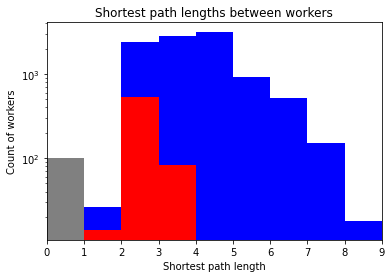

In [35]:
import numpy as np
from matplotlib import pyplot as plt

data=list(graphDistances(F,workerIds))
maxDist=max([max(l,default=0) for l in data],default=0)
colors=["grey","red","blue"]
labels=["self","same community","other community"]
# fixed bin size
bins = np.arange(0, 100, 1) # fixed bin size

plt.xlim([0, maxDist+1])
plt.yscale("log")
plt.hist(data, bins=bins, color=colors, label=labels, stacked=True)
plt.title('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')

plt.show()

In [36]:
#the greater the value, the better
print(sum([sum(l) for l in data]))

34482


### Intra cluster distances

Same Counter({3: 18, 2: 12})
Other Counter({3: 263, 4: 179, 2: 59, 5: 30, 6: 24, 7: 9})
Same Counter({2: 42, 3: 30})
Other Counter({3: 313, 2: 255, 4: 183, 5: 41, 6: 27})
Same Counter({2: 12})
Other Counter({2: 145, 3: 143, 4: 64, 5: 20, 6: 12})
Same Counter({2: 12})
Other Counter({4: 118, 3: 114, 2: 107, 5: 21, 6: 10, 7: 9, 1: 5})
Same Counter({2: 30, 3: 12})
Other Counter({2: 233, 3: 191, 4: 172, 5: 39, 6: 15, 1: 1})
Same Counter({2: 72})
Other Counter({3: 300, 2: 271, 4: 176, 5: 45, 6: 27})
Same Counter({2: 156})
Other Counter({3: 431, 2: 339, 4: 258, 5: 66, 6: 36, 1: 1})
Same Counter({2: 20, 3: 10})
Other Counter({4: 284, 5: 133, 3: 115, 6: 25, 2: 4, 7: 3})
Same Counter({2: 26, 1: 4})
Other Counter({4: 369, 2: 87, 5: 36, 3: 33, 6: 18, 7: 18, 1: 3})
Same Counter({2: 30})
Other Counter({4: 340, 2: 89, 3: 63, 5: 35, 7: 18, 6: 17, 1: 2})
Same Counter({2: 8, 1: 4})
Other Counter({4: 184, 3: 168, 5: 12, 6: 12, 2: 8})
Same Counter({2: 12})
Other Counter({5: 183, 6: 75, 3: 60, 4: 42, 7: 9,

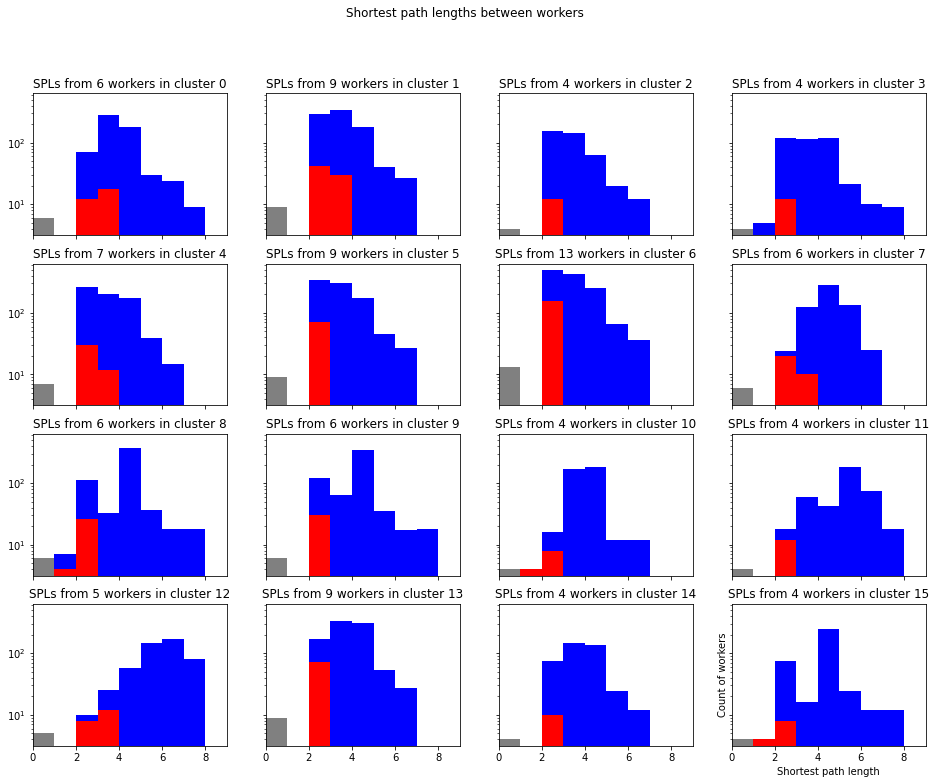

In [37]:
import numpy as np
from matplotlib import pyplot as plt

nbClusters=len(partition.subgraphs())
nbCol=4
fig,ax = plt.subplots(nrows = nbClusters//nbCol, ncols = nbCol,sharex=True, sharey=True,figsize=(nbCol*4,3*nbClusters//nbCol))

for idx, subgraph in enumerate(partition.subgraphs()):
    inClusterWorkers=[w for w in workerIds if w in subgraph.vs["name"]]
    data=list(graphDistances(F,inClusterWorkers,workerIds,subgraph.vs[0]["cluster"]))
    colors=["grey","red","blue"]
    labels=["self","same community","other community"]

    # fixed bin size
    bins = np.arange(0, maxDist+1, 1) # fixed bin size

    ax[idx//nbCol][idx%nbCol].hist(data, bins=bins, color=colors, label=labels, stacked=True)
    ax[idx//nbCol][idx%nbCol].title.set_text('SPLs from {} worker{} in cluster {}'.format(len(inClusterWorkers),"s" if len(inClusterWorkers)>1 else "",idx))
plt.xlim([0, maxDist+1])
plt.yscale("log")
plt.suptitle('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')
plt.show()

## Graph Metrics

### Max distance between nodes (graph diameter)

In [38]:
print(F.diameter())

8


### Distances inter-nodes intra-clusters (cluster diameters)

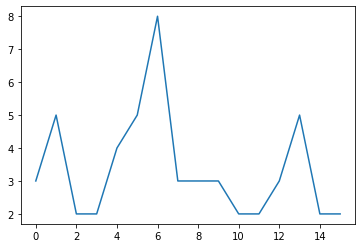

In [39]:
subgraphs=partition.subgraphs()
diameters=list([subgraph.diameter() for subgraph in subgraphs])
plt.plot(diameters)

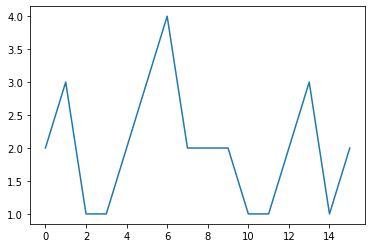

In [40]:
radii=list([subgraph.radius() for subgraph in subgraphs])
plt.plot(radii)

### Nodes per community

In [41]:
from collections import Counter
nbClusters=len(Counter(F.vs["cluster"]))

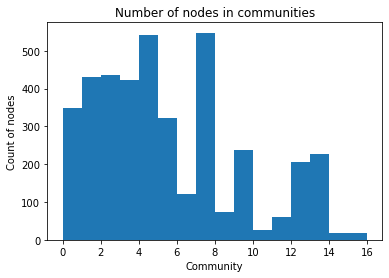

In [42]:
bins = np.arange(0, nbClusters+1, 1)
plt.hist(F.vs["cluster"], bins=bins)
plt.title('Number of nodes in communities')
plt.xlabel('Community')
plt.ylabel('Count of nodes')

plt.show()

### Workers per cluster

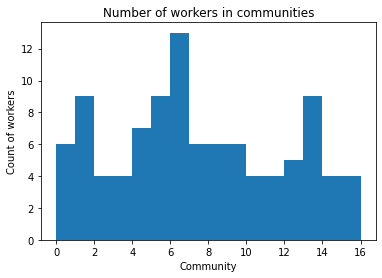

In [43]:
data=[F.vs.find(worker)["cluster"] for worker in workerIds]
bins = np.arange(0, nbClusters+1, 1)
plt.hist(data, bins=bins)
plt.title('Number of workers in communities')
plt.xlabel('Community')
plt.ylabel('Count of workers')

plt.show()

### Cluster diameter based worker count

In [44]:
diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]

workers=[diameter//2+diameter%2 for diameter in diameters]
assignedWorkers=sum(workers)
print(assignedWorkers)

31
